In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D

from keras.applications.densenet import DenseNet121
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamaravichow","key":"a3961eb688fd6779ec65395efba95faf"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

In [5]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [01:39<00:00, 24.1MB/s]
100% 2.06G/2.06G [01:39<00:00, 22.2MB/s]


In [ ]:
!mkdir data
!unzip /content/chest-xray-covid19-pneumonia.zip -d /content/data

In [7]:
len(os.listdir("/content/data/Data/train/COVID19"))

460

In [8]:
train_dir = "/content/data/Data/train/"
test_dir = "/content/data/Data/test/"

print("Train set:\n========================================")
num_covid = len(os.listdir(os.path.join(train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"COVID={num_covid}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"COVID = {len(os.listdir(os.path.join(test_dir, 'COVID19')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

Train set:
COVID=460
NORMAL=1266
Test set:
COVID = 116
NORMAL = 317


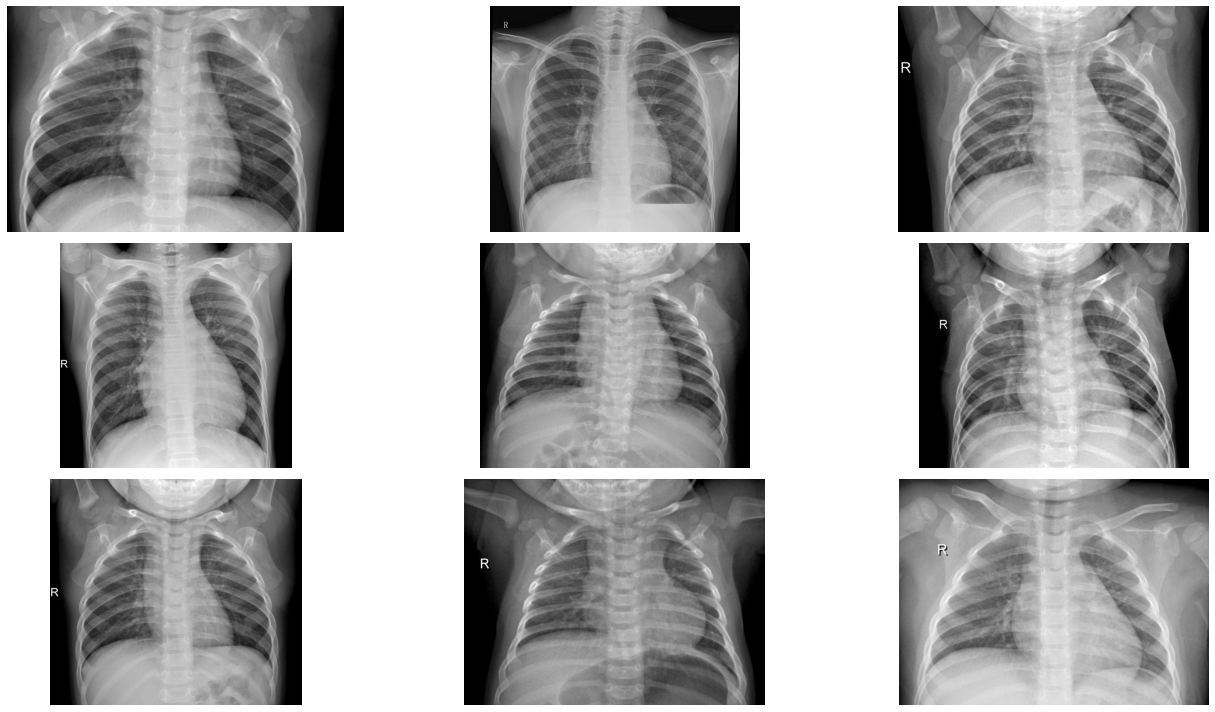

In [9]:
normal = os.listdir("/content/data/Data/train/NORMAL")
normal_dir = "/content/data/Data/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

The dimensions of the image are 948 pixels width and 1413 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 119.1563 and the standard deviation is 57.4068


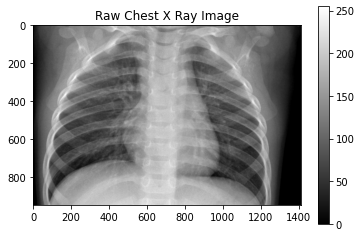

In [10]:
normal_img = os.listdir("/content/data/Data/train/NORMAL")[0]
normal_dir = "/content/data/Data/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

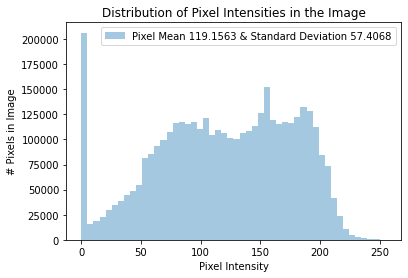

In [11]:
sns.distplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [12]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [13]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            classes = ["NORMAL", "COVID19"],
                                            class_mode='binary',
                                            target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            classes = ["NORMAL", "COVID19"],
                                            class_mode='binary',
                                            target_size=(320, 320))

Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


The dimensions of the image are 320 pixels width and 320 pixels height, one single color channel.
The maximum pixel value is 8.3761 and the minimum is -3.6518
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


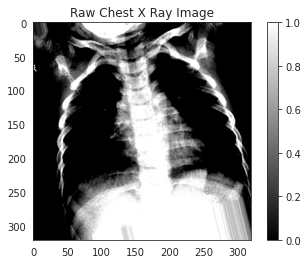

In [14]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

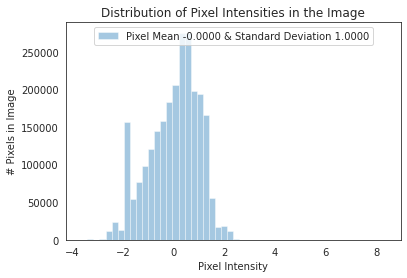

In [15]:
sns.distplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [16]:
# Class weights

weight_for_0 = num_covid / (num_normal + num_covid)
weight_for_1 = num_normal / (num_normal + num_covid)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.27
Weight for class 1: 0.73


In [17]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',f1_m, precision_m, recall_m])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 318, 318, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 316, 316, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 316, 316, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 158, 158, 32)     0         
 )                                                               
                                                        

In [20]:
r = model.fit(
    train, 
    epochs=10,
    class_weight=class_weight,
)

Epoch 1/10
216/216 [==============================] - 110s 456ms/step - loss: 1.1222 - accuracy: 0.8934 - f1_m: 0.7481 - precision_m: 0.7304 - recall_m: 0.8177
Epoch 2/10
216/216 [==============================] - 99s 459ms/step - loss: 0.1584 - accuracy: 0.9200 - f1_m: 0.7885 - precision_m: 0.7683 - recall_m: 0.8461
Epoch 3/10
216/216 [==============================] - 102s 472ms/step - loss: 0.0958 - accuracy: 0.9513 - f1_m: 0.8384 - precision_m: 0.8272 - recall_m: 0.8768
Epoch 4/10
216/216 [==============================] - 101s 466ms/step - loss: 0.0641 - accuracy: 0.9537 - f1_m: 0.8375 - precision_m: 0.8255 - recall_m: 0.8766
Epoch 5/10
216/216 [==============================] - 100s 461ms/step - loss: 0.0762 - accuracy: 0.9629 - f1_m: 0.8448 - precision_m: 0.8465 - recall_m: 0.8645
Epoch 6/10
216/216 [==============================] - 103s 478ms/step - loss: 0.1076 - accuracy: 0.9594 - f1_m: 0.8386 - precision_m: 0.8337 - recall_m: 0.8673
Epoch 7/10
216/216 [=====================

In [21]:
model.save("mv1-cov19xray.h5")

Text(0.5, 1.0, 'Accuracy Evolution')

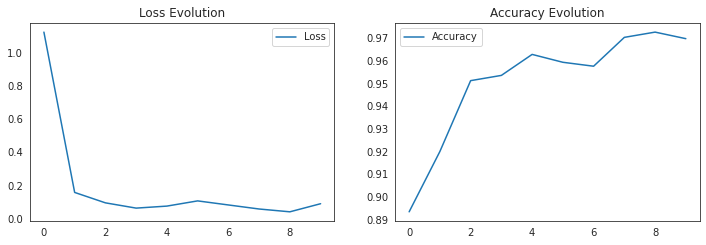

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [23]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

loss, accuracy, f1_score, precision, recall = model.evaluate(train)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

433/433 [==============================] - 28s 64ms/step - loss: 0.1437 - accuracy: 0.9584 - f1_m: 0.2402 - precision_m: 0.2402 - recall_m: 0.2402
Test Accuracy: 95.84%
216/216 [==============================] - 97s 445ms/step - loss: 0.2438 - accuracy: 0.9583 - f1_m: 0.8371 - precision_m: 0.8461 - recall_m: 0.8505
Train Accuracy: 95.83%


In [24]:
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

433/433 [==============================] - 25s 56ms/step
[[309   8]
 [ 11 105]]


,0,1,accuracy,macro avg,weighted avg
precision,0.965625,0.929204,0.95612,0.947414,0.955868
recall,0.974763,0.905172,0.95612,0.939968,0.956120
f1-score,0.970173,0.917031,0.95612,0.943602,0.955936
support,317.000000,116.000000,0.95612,433.000000,433.000000


In [25]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[311   6]
 [ 12 104]]


,0,1,accuracy,macro avg,weighted avg
precision,0.962848,0.945455,0.95843,0.954151,0.958189
recall,0.981073,0.896552,0.95843,0.938812,0.958430
f1-score,0.971875,0.920354,0.95843,0.946114,0.958073
support,317.000000,116.000000,0.95843,433.000000,433.000000


In [26]:
print(test.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [27]:
print(len(test))

433
